
# Fermi-LAT with Gammapy

Data inspection and preliminary analysis with Fermi-LAT data.

## Introduction

Gammapy fully supports Fermi-LAT data analysis from DL4 level (binned
maps). In order to perform data reduction from the events list and
spacecraft files to binned counts and IRFs maps we recommend to use
[Fermipy](http://fermipy.readthedocs.io/)_, which is based on
the [Fermi Science
Tools](https://fermi.gsfc.nasa.gov/ssc/data/analysis/software/)_
(Fermi ST).

Using Gammapy with Fermi-LAT data could be an option for you if you want
to do an analysis that is not easily possible with Fermipy and the Fermi
Science Tools. For example a joint likelihood fit of Fermi-LAT data with
data e.g. from H.E.S.S., MAGIC, VERITAS or some other instrument, or
analysis of Fermi-LAT data with a complex spatial or spectral model that
is not available in Fermipy or the Fermi ST.

This tutorial will show you how to convert Fermi-LAT data into a DL4
format  that can be used by Gammapy (`~gammapy.datasets.MapDataset`) and perform a 3D analysis. As an
example, we will look at the Galactic center.
We are going to analyses high-energy data from 10 GeV from 1 TeV (in reconstructed energy).

## Setup

For this notebook you have to get the prepared
`fermi-gc` data provided in your `$GAMMAPY_DATA`.


In [1]:
# %matplotlib inline

import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt

from gammapy.catalog import CATALOG_REGISTRY
from gammapy.datasets import Datasets, FermipyDatasetsReader
from gammapy.estimators import TSMapEstimator
from gammapy.maps import Map
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    PointSpatialModel,
    PowerLawSpectralModel,
    TemplateSpatialModel,
    SkyModel,
    PowerLawNormSpectralModel,
)
from gammapy.utils.scripts import make_path

### Check setup

We check the setup in this tutorial, as we require specific files to be
downloaded to continue.



In [2]:
from gammapy.utils.check import check_tutorials_setup

check_tutorials_setup()


System:

	python_executable      : /Users/qremy/anaconda3/envs/gpy-dev/bin/python 
	python_version         : 3.11.10    
	machine                : x86_64     
	system                 : Darwin     


Gammapy package:

	version                : 2.0.dev2046+g36d1c660f 
	path                   : /Users/qremy/Work/GitHub/gammapy/gammapy 



OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.



Other packages:

	numpy                  : 2.1.3      
	scipy                  : 1.16.1     
	astropy                : 7.1.0      
	regions                : 0.10       
	click                  : 8.1.7      
	yaml                   : 6.0.2      
	IPython                : 8.27.0     
	jupyterlab             : 4.2.5      
	matplotlib             : 3.9.0      
	pandas                 : 2.2.3      
	healpy                 : 1.18.0     
	iminuit                : 2.30.1     
	sherpa                 : not installed 
	naima                  : 0.10.0     
	emcee                  : 3.1.4      
	corner                 : 2.2.2      
	ray                    : 2.40.0     


Gammapy environment variables:

	GAMMAPY_DATA           : /Users/qremy/Work/GitHub/gammapy-data 



## Fermipy configuration file

Gammapy can utilise the same configuration file as Fermipy to convert
the Fermipy-generated maps into Gammapy datasets. For more information on the
structure of these files, refer to the [Fermipy configuration
page](https://fermipy.readthedocs.io/en/latest/config.html)_. In this
tutorial, we will analyse Galactic center data generated with Fermipy version 1.3 and
the configuration given in
`$GAMMAPY_DATA/fermi-gc/config_fermipy_gc_example.yaml`:




```yaml

# Fermipy example configuration
# for details, see https://fermipy.readthedocs.io/en/latest/config.html
# For IRFs, event type and event class options, see https://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone_Data/LAT_DP.html
   components:
     - model: {isodiff: $FERMI_DIR/refdata/fermi/galdiffuse/iso_P8R3_CLEAN_V3_PSF2_v1.txt}
       selection: {evtype: 16}  #4 is PSF0, 8 PSF1, 16 PSF2, 32 PSF3
       data: {ltcube: null}
     - model: {isodiff: $FERMI_DIR/refdata/fermi/galdiffuse/iso_P8R3_CLEAN_V3_PSF3_v1.txt}
       selection: {evtype: 32}
       data: {ltcube: null}

   data:
     evfile : ./raw/events_list.lst
     scfile : ./raw/L241227031840F357373F12_SC00.fits

   binning:
     roiwidth   : 8.0
     binsz      : 0.1
     binsperdec   : 10
     coordsys : GAL
     proj: CAR
     projtype: WCS

   selection :
   # gtselect parameters
     emin : 3981.0717055349733 # ENERGY TRUE for Gammapy
     emax : 2511886.4315095823 # ENERGY TRUE for Gammapy
     zmax    : 105 # deg
     evclass : 256 # CLEAN
     tmin    : 239557417
     tmax    : 752112005

   # gtmktime parameters
     filter : 'DATA_QUAL>0 && LAT_CONFIG==1'
     roicut : 'no'

   # Set the ROI center to the coordinates of this source
     glon : 0.
     glat : 0.

   fileio:
      outdir : ''
      logfile : 'out.log'
      usescratch : False
      scratchdir  : '/scratch'

   gtlike:
     edisp : True
     edisp_bins : 0 # DO NOT CHANGE edisp_bins will be handled by Gammapy
     irfs : 'P8R3_CLEAN_V3'

   model:
     src_roiwidth : 10.0 # This is used by Fermipy to compute the PSF RADMAX, even if no models are set


```

The most important points for Gammapy users are:

- ``emin`` and ``emax`` in this file should be considered as the energy true range.
  It should be larger that the reconstructed energy range.
- ``edisp_bins : 0`` is strongly recommended at this stage otherwise you
  might face inconsistencies in the energy axes of the different IRFs created by Fermipy.
- The ``edisp_bins`` value will be redefined later on by Gammapy as a positive value
  in order to create the reconstructed energy axis properly.
- If you want to use the `$FERMI_DIR` variable to read the background models
  it must also be defined in your Gammapy environment,
  otherwise you have to define your own paths.
- For this tutorial we copied the iso files in `$GAMMAPY_DATA/fermi-gc` and
  edited the paths in the yaml file for simplicity.

More generally in order to select a good binning it is important to know
the instrument resolution, for that you can have a quick look at the
IRFs in the [Fermi-LAT performance
page](https://www.slac.stanford.edu/exp/glast/groups/canda/lat_Performance.htm)_.

Since the energy resolution varies with energy, it is important to
choose an energy binning that is fine enough to capture this energy
dependence. That is why we recommend a binning with 8 to 10 bins per
decade. The energy axes will be created such as it is linear in log space
so it's better to define ``emin`` and ``emax`` such as they align with a log binning.
Here we have as true energy range $\log(emin) = 0.6 \sim 4$ GeV to
$\log(emax) = 3.4 \sim 2500$ GeV.
While the reconstructed energy range of our analysis will be 10 GeV to 1000 GeV.

The spatial binning should be of the same order of the PSF 68%
containment radius which is in average 0.1 degree above 10 GeV and
rapidly increases at lower energy. Ideally it should remain within a
factor of 2 or 3 of the PSF radius at most. In order to properly take
into account for the sources outside the region of interest that
contribute inside due to the PSF we have to define a wider ``roiwidth``
than our actual region of interest. Typically, we need a margin equal to the
99% containment of the PSF on each side. Above 10 GeV considering only
PSF2&3 the 99% PSF containment radius is about 1 degree. Thus, if we
want to study a 3 degree radius around the GC we have to take a ``roiwidth`` of 8
deg. (If considering lower energies or including PSF0 and PSF1, it should be much
larger).




## From Fermipy maps to Gammapy datasets

In your Fermipy environment you have to run the following commands

```python

   from fermipy.gtanalysis import GTAnalysis
   gta = GTAnalysis('config_fermipy_gc_example.yaml',logging={'verbosity' : 3})
   gta.setup()

   gta.compute_psf(overwrite=True) # this creates the psf kernel
   gta.compute_drm(edisp_bins=0, overwrite=True) # this creates the energy dispersion matrix
   # DO NOT CHANGE edisp_bins here, it will be redefined by Gammapy later on
```

This will produce a number of files including:

- “ccube_00.fits” (counts)
- “bexpmap_00.fits” (exposure)
- “psf_00.fits” (psf)
- “drm_00.fits” (edisp)





In your Gammapy environment you can create the datasets using the
same configuration file.




In [3]:
reader = FermipyDatasetsReader(
    "$GAMMAPY_DATA/fermi-gc/config_fermipy_gc_example.yaml", edisp_bins=4
)
datasets = reader.read()
print(datasets)

Set MJD-OBS to 54682.655283 from DATE-OBS.
Set MJD-END to 60614.993543 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 54682.655283 from DATE-OBS.
Set MJD-END to 60614.993543 from DATE-END'. [astropy.wcs.wcs]


Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : P8R3_CLEAN_V3_PSF2_v1
  Instrument : 
  Models     : ['isotropic_P8R3_CLEAN_V3_PSF2_v1']

Dataset 1: 

  Type       : MapDataset
  Name       : P8R3_CLEAN_V3_PSF3_v1
  Instrument : 
  Models     : ['isotropic_P8R3_CLEAN_V3_PSF3_v1']




Note that the ``edisp_bins`` is set again here as a positive number so
Gammapy can create its reconstructed energy axis properly. The energy
dispersion correction implemented Gammapy is closer to the version
implemented in Fermitools >1.2.0, which take into account the interplay
between the energy dispersion and PSF.

Across most of the Fermi energy range, the level of migration in log10(E)
remains within 0.2, increasing up to 0.4 below 100 MeV,
due to energy dispersion. Therefore, we recommend that the
product of \|edisp_bins\| and the width of the log10(E) bins be at
least equal to 0.2. For a binning of 8 to 10 bins per decade, this
corresponds to \|edisp_bins\| ≥ 2. For further information, see
[Pass8_edisp_usage](https://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Pass8_edisp_usage.html)_.
In our case, we have 10 bins per decade and true energy axis starts
at about 4 GeV, so with ``edisp_bins=4`` the reconstructed energy axis
starts at 10 GeV:




In [4]:
print(datasets[0].exposure.geom.axes["energy_true"])
print(datasets[0].counts.geom.axes["energy"])

MapAxis

	name       : energy_true
	unit       : 'MeV'     
	nbins      : 28        
	node type  : edges     
	edges min  : 4.0e+03 MeV
	edges max  : 2.5e+06 MeV
	interp     : log       

MapAxis

	name       : energy    
	unit       : 'MeV'     
	nbins      : 20        
	node type  : edges     
	edges min  : 1.0e+04 MeV
	edges max  : 1.0e+06 MeV
	interp     : log       



Note that selecting ``edisp_bins=2`` means the reconstructed energy
of the counts geometry will start at $10^{0.8} \sim 6.3$ GeV.
If we want to start the analysis at 10 GeV in this case, we need to
update the ``mask_fit`` to exclude the first 2 reconstructed energy bins.
Considering more ``edisp_bins`` is generally safer but requires more memory
and increases computation time.

Alternatively, if you created the counts and IRF files from the
Fermi-LAT science tools without Fermipy you can use the
``create_dataset``  method. Note that in this case we cannot guarantee
that your maps have the correct axes dimensions to be properly converted
into Gammapy datasets.




In [5]:
path = make_path("$GAMMAPY_DATA/fermi-gc")
dataset0 = reader.create_dataset(
    path / "ccube_00.fits",
    path / "bexpmap_00.fits",
    path / "psf_00.fits",
    path / "drm_00.fits",
    isotropic_file=None,
    edisp_bins=0,
    name="fermi_lat_gc_psf2",
)
dataset1 = reader.create_dataset(
    path / "ccube_01.fits",
    path / "bexpmap_01.fits",
    path / "psf_01.fits",
    path / "drm_01.fits",
    isotropic_file=None,
    edisp_bins=0,
    name="fermi_lat_gc_psf3",
)

datasets_fromST = Datasets([dataset0, dataset1])


# The above was an alternative reading method we don't need those after
del dataset0, dataset1, datasets_fromST

Set MJD-OBS to 54682.655283 from DATE-OBS.
Set MJD-END to 60614.993543 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 54682.655283 from DATE-OBS.
Set MJD-END to 60614.993543 from DATE-END'. [astropy.wcs.wcs]


## Fermi-LAT IRF properties

### Exposure




Exposure is almost constant across the field of view, with less than 5%
variation at a given energy.




In [6]:
datasets[0].exposure.plot_interactive(add_cbar=True)
plt.show()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

### PSF

For Fermi-LAT, the PSF only varies little within a given regions of
the sky, especially at high energies like what we have here.
So we have only one PSF kernel.




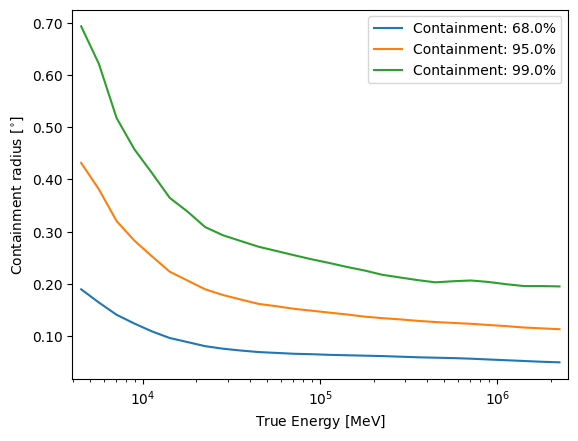

In [7]:
datasets[0].psf.plot_containment_radius_vs_energy(fraction=(0.68, 0.95, 0.99))
plt.show()

## Region of interest and mask definition

As mentioned previously, the width of dataset is larger that our actual
region of interest in order to properly take into account for the
sources outside that contributes inside due to the PSF. So we define the
valid RoI for fitting by creating a ``mask_fit``.




In [8]:
margin = (
    2.0 * u.deg
)  # >1 deg should be fine for this dataset we take 2 so the notebook is faster
geom = datasets[0].counts.geom
mask_fit = Map.from_geom(geom, data=True, dtype=bool)
mask_fit = mask_fit.binary_erode(width=margin, kernel="disk")

mask_fit.plot_interactive()
plt.show()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

Now we attach it the datasets




In [9]:
for d in datasets:
    d.mask_fit = mask_fit

## Models

### Isotropic diffuse background

The `~gammapy.datasets.FermipyDatasetsReader` also created one isotropic diffuse model
for each dataset:




In [10]:
models_iso = Models(datasets.models)
print(models_iso)

Models

Component 0: SkyModel

  Name                      : isotropic_P8R3_CLEAN_V3_PSF2_v1
  Datasets names            : ['P8R3_CLEAN_V3_PSF2_v1']
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : ConstantSpatialModel
  Temporal model type       : 
  Parameters:
    tilt                  (frozen):      0.000                   
    norm                          :      1.000   +/-    0.00             
    reference             (frozen):      1.000       TeV         
    value                 (frozen):      1.000       1 / sr      

Component 1: SkyModel

  Name                      : isotropic_P8R3_CLEAN_V3_PSF3_v1
  Datasets names            : ['P8R3_CLEAN_V3_PSF3_v1']
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : ConstantSpatialModel
  Temporal model type       : 
  Parameters:
    tilt                  (frozen):      0.000                   
    norm                          :      1.000   +/-    0.00             
 

### Galactic diffuse background




The Fermi-LAT collaboration provides a galactic diffuse emission model,
that can be used as a background model for Fermi-LAT source analysis.
These files are called usually IEM for interstellar emission model, the
latest is
[gll_iem_v07.fits](https://fermi.gsfc.nasa.gov/ssc/data/analysis/software/aux/4fgl/gll_iem_v07.fits)_.
For details see the [BackgroundModels
page](https://fermi.gsfc.nasa.gov/ssc/data/access/lat/BackgroundModels.html)_.
If you have Fermipy installed it can also be found in
`$FERMI_DIR/refdata/fermi/galdiffuse/gll_iem_v07.fits`

Diffuse model maps are very large (100s of MB), so as an example here,
we just load one that represents a small cutout for the Galactic center
region.

In this case, the maps are already in differential units, so we do not
want to normalise it again.




In [11]:
template_iem = TemplateSpatialModel.read(
    filename="$GAMMAPY_DATA/fermi-gc/gll_iem_v07_gc.fits.gz", normalize=False
)

model_iem = SkyModel(
    spectral_model=PowerLawNormSpectralModel(),
    spatial_model=template_iem,
    name="diffuse-iem",
)

Let’s look at the template :




In [12]:
template_iem.map.plot_interactive(add_cbar=True)
plt.show()


models_diffuse = models_iso + model_iem

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

### Sources

Source models can be loaded from the 4FGL catalog directly available in
`$GAMMAPY_DATA`. For details see the [Fermi-LAT catalog
page](https://fermi.gsfc.nasa.gov/ssc/data/access/lat/14yr_catalog/)_.




In [13]:
catalog_4fgl = CATALOG_REGISTRY.get_cls("4fgl")()  # load 4FGL catalog

We want to select only the sources inside the dataset spatial geometry:




In [14]:
in_geom = geom.to_image().contains(catalog_4fgl.positions)
catalog_4fgl_gc = catalog_4fgl[in_geom]

models_4fgl_gc = catalog_4fgl_gc.to_models()

/Users/qremy/Work/GitHub/gammapy/gammapy/catalog/fermi.py:587: UserWarning: Warning: converting a masked element to nan.
  "index_2": np.nan_to_num(float(self.data["Unc_PLEC_Exp_Index"])),
/Users/qremy/Work/GitHub/gammapy/gammapy/catalog/fermi.py:587: UserWarning: Warning: converting a masked element to nan.
  "index_2": np.nan_to_num(float(self.data["Unc_PLEC_Exp_Index"])),
/Users/qremy/Work/GitHub/gammapy/gammapy/catalog/fermi.py:587: UserWarning: Warning: converting a masked element to nan.
  "index_2": np.nan_to_num(float(self.data["Unc_PLEC_Exp_Index"])),


That's still quite a lot of sources




In [15]:
print("Number of source models", len(models_4fgl_gc))

Number of source models 110


In order to improve performances we can store all the sources outside
the ``mask_fit`` region into a single template (the same could be done
for all the sources we want to keep frozen).




In [16]:
sources_ouside_roi = models_4fgl_gc.select_mask(~mask_fit, use_evaluation_region=False)
sources_inside_roi = Models([m for m in models_4fgl_gc if m not in sources_ouside_roi])

geom_true = datasets[0].exposure.geom
sources_outside_roi = sources_ouside_roi.to_template_sky_model(
    geom_true, name="sources_outside"
)

sources_outside_roi.spatial_model.filename = "sources_outside.fits"

sources_outside_roi.spatial_model.map.plot_interactive(add_cbar=True)
plt.show()

The filename is not defined. Therefore, the model will not be serialised correctly. To set the filename, the "template_model.filename" attribute can be used.


interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

Now we have less models to describe the sources




In [17]:
models_sources = sources_inside_roi + sources_outside_roi

print("Number of source models", len(models_sources))

Number of source models 28


## Fit

Now, the big finale: let’s do a 3D of the brightest sources and IEM
models.

First we attach the models to the datasets.




In [18]:
models = models_sources + models_diffuse

datasets.models = models

print("Number of models", len(models))

Number of models 31


Let’s find the 3 brightest sources:




In [19]:
n_brightest = 3
integrated_flux = u.Quantity(
    [m.spectral_model.integral(10 * u.GeV, 1 * u.TeV) for m in sources_inside_roi]
)
order = np.argsort(integrated_flux)
selected_sources = Models([sources_inside_roi[int(ii)] for ii in order[:n_brightest]])

print(selected_sources.names)

free_models = selected_sources + model_iem

['4FGL J1739.4-3015', '4FGL J1751.6-3002', '4FGL J1754.3-2915']


We keep only their normalisation free for simplicity:




In [20]:

models.freeze()  # freeze all parameters

# and unfreeze only the amplitude or norm of the selected models
for p in free_models.parameters:
    if p.name in ["amplitude", "norm"]:
        p.frozen = False
        p.min = 0

print("Number of free parameters", len(models.parameters.free_parameters))


Number of free parameters 4


In [21]:
%%time

fit = Fit()
result = fit.run(datasets=datasets)

print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 97
	total stat : 20322.54

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

CPU times: user 5.21 s, sys: 84 ms, total: 5.29 s
Wall time: 5.3 s


## Residual TS map

Now we can look at the residual TS map to check there is no significant
excess left:




In [22]:
spatial_model = PointSpatialModel()
spectral_model = PowerLawSpectralModel(index=2)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

ts_estimator = TSMapEstimator(
    model,
    kernel_width="1 deg",  # this set close to the 95-99% containment radius of the PSF
    selection_optional=[],
    sum_over_energy_groups=True,
    energy_edges=[10, 1000] * u.GeV,
)

In [23]:
%%time
ts_results = ts_estimator.run(datasets)


CPU times: user 2.57 s, sys: 45.7 ms, total: 2.61 s
Wall time: 2.61 s


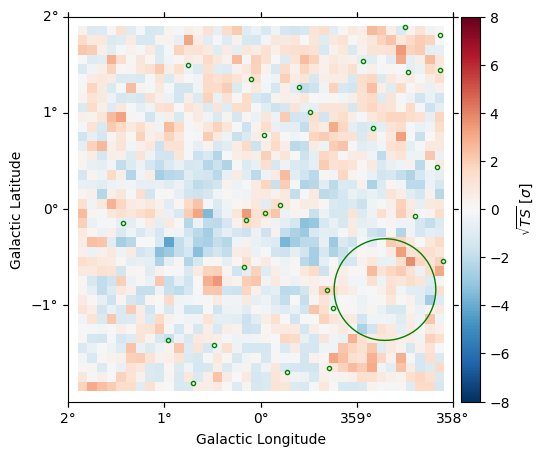

In [24]:
image = ts_results["sqrt_ts"]
image = image.cutout(
    image.geom.center_skydir, width=np.max(image.geom.width) - 2 * margin
)

fig = plt.figure(figsize=(7, 5))
ax = image.plot(
    clim=[-8, 8],
    cmap=plt.cm.RdBu_r,
    add_cbar=True,
    kwargs_colorbar={"label": r"$\sqrt{TS}$ [$\sigma$]"},
)
sources_inside_roi.plot_regions(
    ax=ax, edgecolor="g", linestyle="-", kwargs_point=dict(marker=".")
)
plt.show()

## Serialisation

To serialise the created dataset, you must proceed through the Datasets
API




In [25]:
datasets.write(
    filename="fermi_lat_gc_datasets.yaml",
    filename_models="fermi_lat_gc_models.yaml",
    overwrite=True,
)
datasets_read = Datasets.read(
    filename="fermi_lat_gc_datasets.yaml", filename_models="fermi_lat_gc_models.yaml"
)

Template file already exits, and overwrite is False
Template file already exits, and overwrite is False
Parameter 'value' not defined in YAML file. Using default value: 1.0 sr-1
Parameter 'value' not defined in YAML file. Using default value: 1.0 sr-1


## Exercises

- Fit the position and spectrum of the source [SNR
  G0.9+0.1](http://gamma-sky.net/#/cat/tev/110)_.
- Make maps and fit the position and spectrum of the [Crab
  nebula](http://gamma-sky.net/#/cat/tev/25)_.




## Summary

In this tutorial you have seen how to work with Fermi-LAT data with
Gammapy. You have to use Fermipy or the Fermi ST to perform the data
reduction then you can use Gammapy for analysis using the same methods
that are used to analyse IACT data.


